## Midterm 
We should: 
- Analyze by the use of spark. 
- Analysis should be meaningful
- Comments has to be written explaining each result


#### Import modules

In [1]:
# Import other modules not related to PySpark
# Import PySpark related modules
import os
import sys
import scipy
import seaborn as sns
from pyspark.mllib.stat import Statistics
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import pyspark
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

### Step 1. Load the data

In [2]:
MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'kidney_disease.csv'
# Load the main data set into pyspark data frame 
df = spark.read.option("header",True).csv(filename_data, inferSchema =True)
print('Data frame type: ' + str(type(df)))


Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [3]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- bp: double (nullable = true)
 |-- sg: double (nullable = true)
 |-- al: double (nullable = true)
 |-- su: double (nullable = true)
 |-- rbc: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- pcc: string (nullable = true)
 |-- ba: string (nullable = true)
 |-- bgr: double (nullable = true)
 |-- bu: double (nullable = true)
 |-- sc: double (nullable = true)
 |-- sod: double (nullable = true)
 |-- pot: double (nullable = true)
 |-- hemo: double (nullable = true)
 |-- pcv: string (nullable = true)
 |-- wc: string (nullable = true)
 |-- rc: string (nullable = true)
 |-- htn: string (nullable = true)
 |-- dm: string (nullable = true)
 |-- cad: string (nullable = true)
 |-- appet: string (nullable = true)
 |-- pe: string (nullable = true)
 |-- ane: string (nullable = true)
 |-- classification: string (nullable = true)

Columns overview


,Column Name,Data type
0,id,int
1,age,double
2,bp,double
3,sg,double
4,al,double
5,su,double
6,rbc,string
7,pc,string
8,pcc,string
9,ba,string


In [4]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,id,age,bp,sg,al,su,rbc,pc,pcc,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,count,400,391,388,353,354,351,248,335,396,...,330,295,270,398,398,398,399,399,399,400
1,mean,199.5,51.48337595907928,76.46907216494846,1.0174079320113256,1.0169491525423728,0.45014245014245013,None,None,None,...,38.88449848024316,8406.122448979591,4.707434944237919,None,None,None,None,None,None,None
2,stddev,115.61430130683084,17.16971408926224,13.68363749352527,0.005716616974376756,1.3526789127628445,1.099191251885407,None,None,None,...,8.990104814740933,2944.4741904103385,1.0253232655721791,None,None,None,None,None,None,None
3,min,0,2.0,50.0,1.005,0.0,0.0,abnormal,abnormal,notpresent,...,\t43,\t6200,\t?,no,\tno,\tno,good,no,no,ckd
4,max,399,90.0,180.0,1.025,5.0,5.0,normal,normal,present,...,9,9900,8.0,yes,yes,yes,poor,yes,yes,notckd


There are total 400 row, Let print first 2 data rows:


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.02,1.0,0.0,None,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.02,4.0,0.0,None,normal,notpresent,notpresent,...,38,6000,None,no,no,no,good,no,no,ckd


In [5]:
df.toPandas()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,None,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,None,normal,notpresent,notpresent,...,38,6000,None,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,None,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [6]:
df.groupby('classification').count().toPandas()

,classification,count
0,notckd,150
1,ckd,248
2,ckd\t,2


In [7]:
numeric_features = [t[0] for t in df.dtypes if t[1] in ['double'] ]
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,391,51.48337595907928,17.16971408926224,2.0,90.0
bp,388,76.46907216494846,13.68363749352527,50.0,180.0
sg,353,1.0174079320113256,0.005716616974376756,1.005,1.025
al,354,1.0169491525423728,1.3526789127628445,0.0,5.0
su,351,0.45014245014245013,1.099191251885407,0.0,5.0
bgr,356,148.0365168539326,79.28171423511773,22.0,490.0
bu,381,57.425721784776904,50.503005849222504,1.5,391.0
sc,383,3.0724543080939934,5.741126066859789,0.4,76.0
sod,313,137.52875399361022,10.408752051798777,4.5,163.0


In [8]:
from pyspark.sql.functions import isnull, when, count, col
# checking null values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+
| id|age| bp| sg| al| su|rbc| pc|pcc| ba|bgr| bu| sc|sod|pot|hemo|pcv| wc| rc|htn| dm|cad|appet| pe|ane|classification|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+
|  0|  9| 12| 47| 46| 49|152| 65|  4|  4| 44| 19| 17| 87| 88|  52| 70|105|130|  2|  2|  2|    1|  1|  1|             0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+



In [4]:
# drop null values
dataset = df.replace('null', None)\
        .dropna(how='any') 
dataset.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
dataset.toPandas()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+
| id|age| bp| sg| al| su|rbc| pc|pcc| ba|bgr| bu| sc|sod|pot|hemo|pcv| wc| rc|htn| dm|cad|appet| pe|ane|classification|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|  0|  0|  0|    0|  0|  0|             0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+



,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
1,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
2,11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
3,14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd
4,20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
154,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
155,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
156,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [5]:
# check unique values for classification column
dataset.select('classification').distinct().rdd.map(lambda r: r[0]).collect()

['notckd', 'ckd']

### Step 2. Filtering data















In [6]:
# changing column types to double type
newdf = dataset.withColumn('rbc', regexp_replace('rbc', 'abnormal', '0'))
newdf = newdf.withColumn('rbc', regexp_replace('rbc', 'normal', '1'))
newdf = newdf.withColumn('pcc', regexp_replace('pcc', 'notpresent', '0'))
newdf = newdf.withColumn('pcc', regexp_replace('pcc', 'present', '1'))
newdf = newdf.withColumn('pc', regexp_replace('pc', 'abnormal', '0'))
newdf = newdf.withColumn('pc', regexp_replace('pc', 'normal', '1'))
newdf = newdf.withColumn('ba', regexp_replace('ba', 'notpresent', '0'))
newdf = newdf.withColumn('ba', regexp_replace('ba', 'present', '1'))
newdf = newdf.withColumn('htn', regexp_replace('htn', 'no', '0'))
newdf = newdf.withColumn('htn', regexp_replace('htn', 'yes', '1'))
newdf = newdf.withColumn('dm', regexp_replace('dm', 'no', '0'))
newdf = newdf.withColumn('dm', regexp_replace('dm', 'yes', '1'))
newdf = newdf.withColumn('cad', regexp_replace('cad', 'no', '0'))
newdf = newdf.withColumn('cad', regexp_replace('cad', 'yes', '1'))
newdf = newdf.withColumn('appet', regexp_replace('appet', 'poor', '0'))
newdf = newdf.withColumn('appet', regexp_replace('appet', 'good', '1'))
newdf = newdf.withColumn('pe', regexp_replace('pe', 'no', '0'))
newdf = newdf.withColumn('pe', regexp_replace('pe', 'yes', '1'))
newdf = newdf.withColumn('ane', regexp_replace('ane', 'no', '0'))
newdf = newdf.withColumn('ane', regexp_replace('ane', 'yes', '1'))
newdf = newdf.withColumn('classification', regexp_replace('classification', 'notckd', '0'))
newdf = newdf.withColumn('classification', regexp_replace('classification', 'ckd', '1'))


changedTypedf = newdf.withColumn("rbc", newdf["rbc"].cast(DoubleType()))
changedTypedf = changedTypedf.withColumn("pcc", changedTypedf["rbc"].cast(DoubleType()))

changedTypedf = changedTypedf.withColumn("pc", changedTypedf["pc"].cast(DoubleType()))
changedTypedf = changedTypedf.withColumn("ba", changedTypedf["ba"].cast(DoubleType()))
changedTypedf = changedTypedf.withColumn("htn", changedTypedf["htn"].cast(DoubleType()))
changedTypedf = changedTypedf.withColumn("dm", changedTypedf["dm"].cast(DoubleType()))
changedTypedf = changedTypedf.withColumn("cad", changedTypedf["cad"].cast(DoubleType()))

changedTypedf = changedTypedf.withColumn("pe", changedTypedf["pe"].cast(DoubleType()))
changedTypedf = changedTypedf.withColumn("appet", changedTypedf["appet"].cast(DoubleType()))

changedTypedf = changedTypedf.withColumn("classification", changedTypedf["classification"].cast(DoubleType()))
changedTypedf = changedTypedf.withColumn("ane", changedTypedf["ane"].cast(DoubleType()))
changedTypedf = changedTypedf.withColumn("pcv", changedTypedf["pcv"].cast(DoubleType()))

changedTypedf = changedTypedf.withColumn("wc", changedTypedf["wc"].cast(DoubleType()))

changedTypedf = changedTypedf.withColumn("rc", changedTypedf["rc"].cast(DoubleType()))

pd.set_option('display.max_columns', None)

changedTypedf.toPandas()


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,3,48.0,70.0,1.005,4.0,0.0,1.0,0.0,1.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1,9,53.0,90.0,1.020,2.0,0.0,0.0,0.0,0.0,0.0,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2,11,63.0,70.0,1.010,3.0,0.0,0.0,0.0,0.0,0.0,380.0,60.0,2.7,131.0,4.2,10.8,32.0,4500.0,3.8,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,14,68.0,80.0,1.010,3.0,2.0,1.0,0.0,1.0,1.0,157.0,90.0,4.1,130.0,6.4,5.6,16.0,11000.0,2.6,1.0,1.0,1.0,0.0,1.0,0.0,1.0
4,20,61.0,80.0,1.015,2.0,0.0,0.0,0.0,0.0,0.0,173.0,148.0,3.9,135.0,5.2,7.7,24.0,9200.0,3.2,1.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,395,55.0,80.0,1.020,0.0,0.0,1.0,1.0,1.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,0.0
154,396,42.0,70.0,1.025,0.0,0.0,1.0,1.0,1.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
155,397,12.0,80.0,1.020,0.0,0.0,1.0,1.0,1.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
156,398,17.0,60.0,1.025,0.0,0.0,1.0,1.0,1.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
print('Columns overview')
pd.DataFrame(changedTypedf.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,id,int
1,age,double
2,bp,double
3,sg,double
4,al,double
5,su,double
6,rbc,double
7,pc,double
8,pcc,double
9,ba,double


### Step 3. Dataset analysis

In [8]:
def correlationMap(df, target) :
    """ 
    Correlation Heatmap
    Inputs : 
        df -- dataframe containing features to plot
        target -- target column name
     """
    classes = df[target].unique()
    if df[target].dtype == 'O' :
        df[target+'_id'] = (df[target]== classes[0]).astype(int) #encode string target 
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corr, vmax=.8,annot=True, square=True)
    if df[target].dtype == 'O' :
        df.drop([target+'_id'], axis=1, inplace=True)
    # fix for matplotlib bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # Gets the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

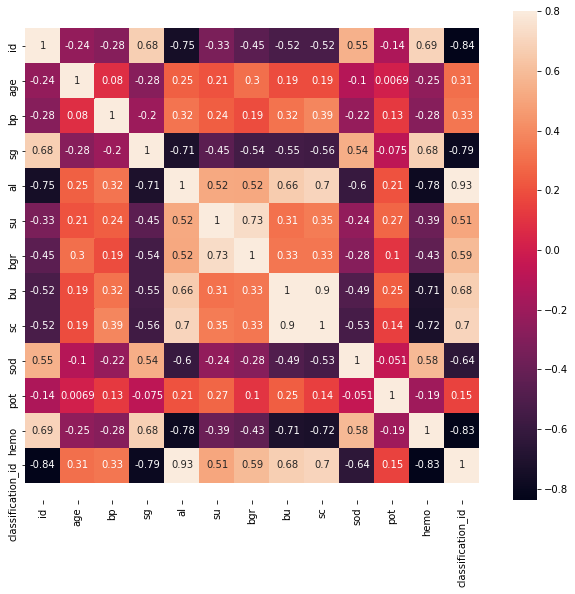

In [9]:
correlationMap(dataset.toPandas(),'classification')
# corr = newdf.toPandas().corr()
# corr.style.background_gradient(cmap='RdBu_r')

- We will say that an absolute value of more than 0.4 is considered to be significant.
- It seems like there are a significant negative correlation between rbc, pc and whether the patient has chronic kidney disease.
- Even so, I will look into age, red blood cell, pus cell, blood glucose random, serum creatinine, diabetes mellitus, coronary artery disease, blood urea, sodium, pedal edema and anemia

### Correlation between age and whether a patient has chronic kidney disease

<Figure size 5040x1800 with 0 Axes>

No handles with labels found to put in legend.


[None, None, None, None]

[None, None]

Text(0.5, 1.0, 'Graph of age vs number of patients with chronic kidney disease')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Age')

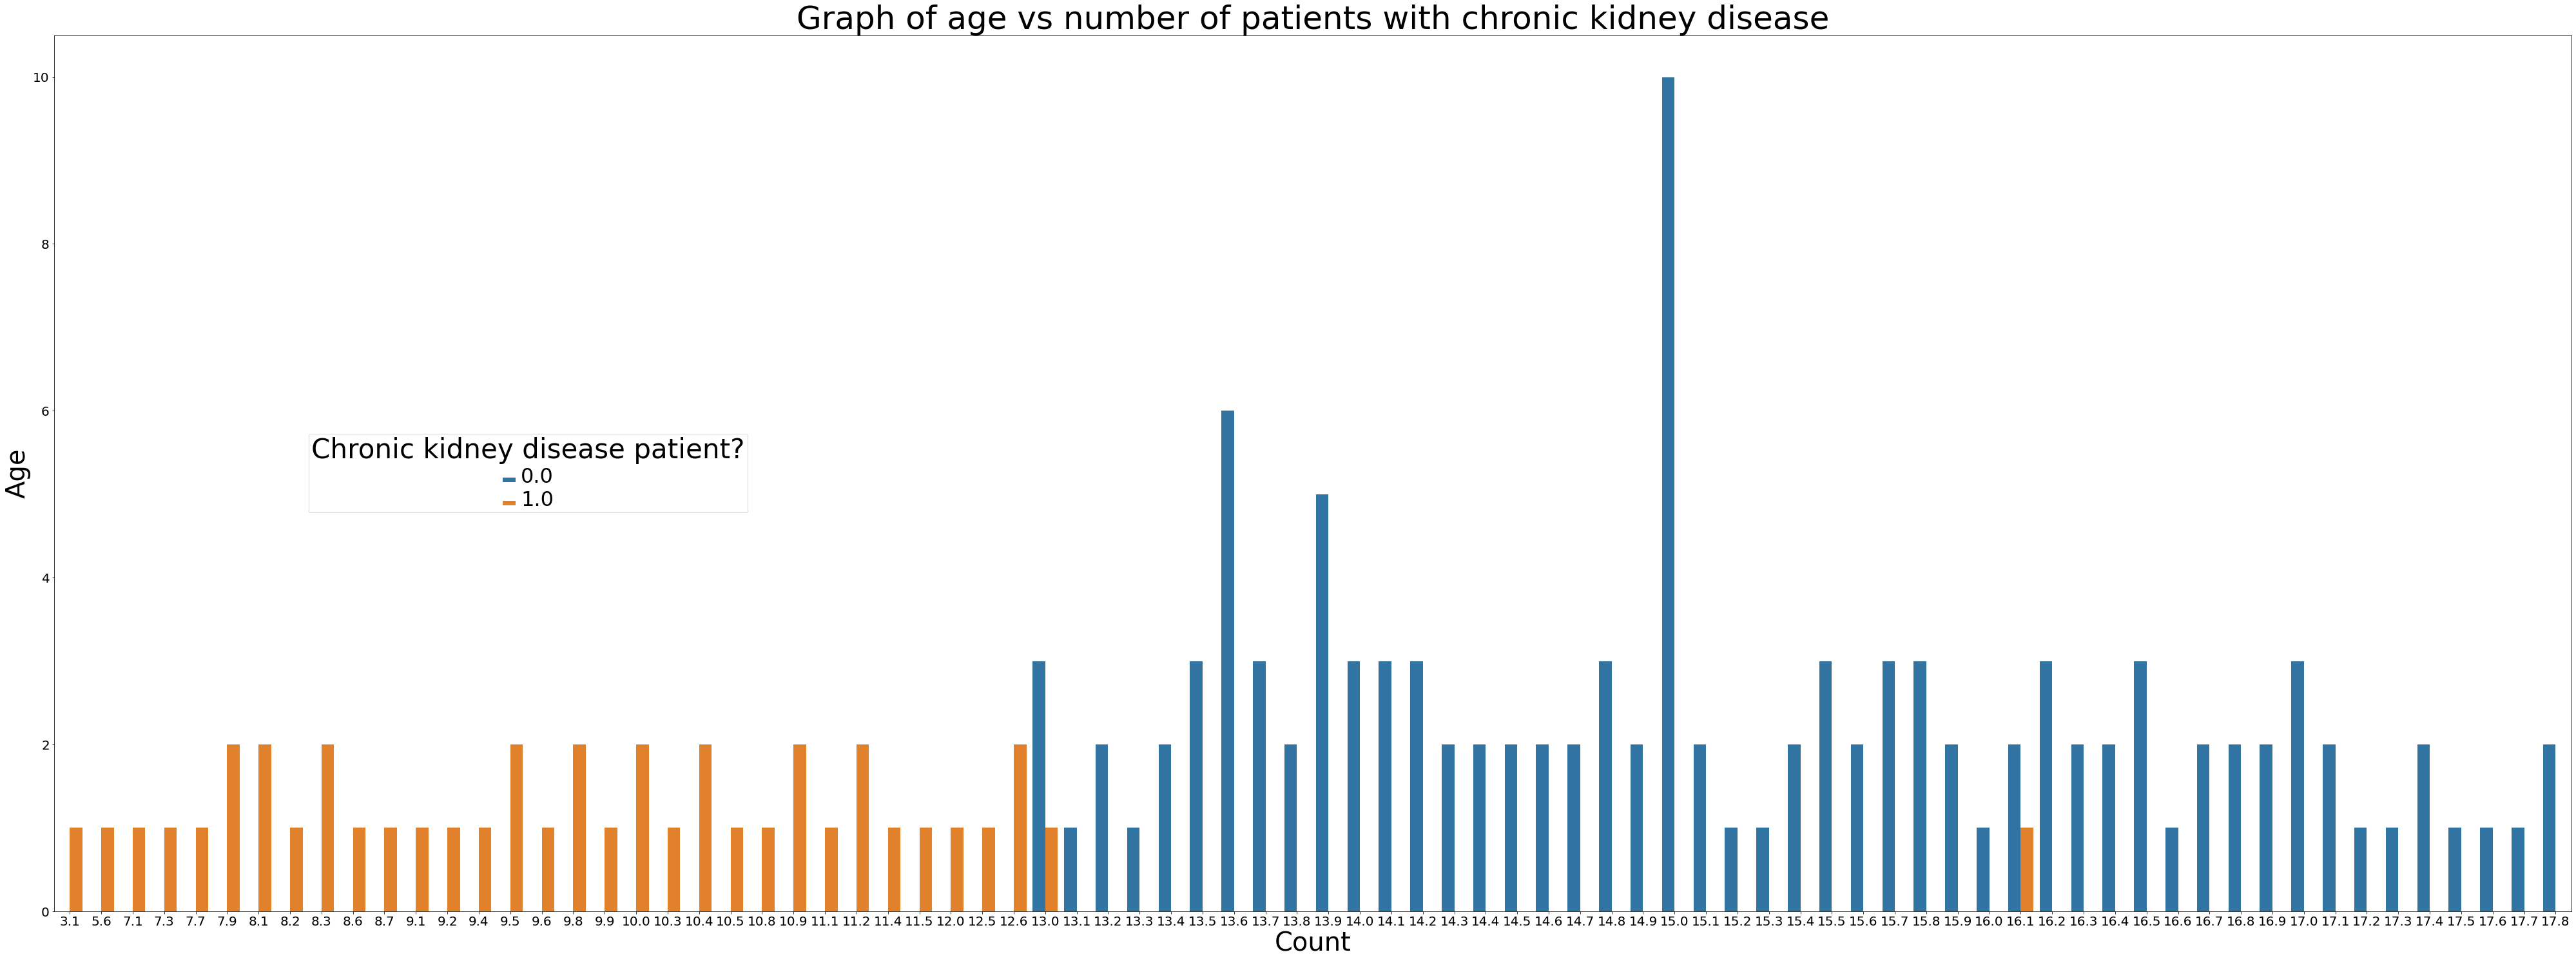

In [13]:
plt.figure(figsize=(70,25))
plt.legend(loc='upper left')
g = sns.countplot(data = changedTypedf.toPandas(), x = 'hemo', hue = 'classification')
g.legend(title = 'Chronic kidney disease patient?', loc='center left', bbox_to_anchor=(0.1, 0.5), ncol=1)
g.tick_params(labelsize=20)
plt.setp(g.get_legend().get_texts(), fontsize='32')
plt.setp(g.get_legend().get_title(), fontsize='42')
g.axes.set_title('Graph of age vs number of patients with chronic kidney disease',fontsize=50)
g.set_xlabel('Count',fontsize=40)
g.set_ylabel("Age",fontsize=40)

### Correlation between red blood cell and whether the patient has chronic kidney disease

Our kidneys create an essential hormone called erythropoietin(EPO). EPO are chemical messengers that plays a key role in the production of red blood cell. Patients with chronic kidney disease has low EPO, resulting in low level of red blood cell. This will eventually lead to anemia.

- Given that the red blood cell here is a nominal data, we will need to use Chi-square test to calculate correlation.
- We will be using 95% confidence interval (95% chance that the confidence interval you calculated contains the true population mean).
    - The null hypothesis is that they are independent.
    - The alternative hypothesis is that they are correlated in some way.

In [82]:
cont = pd.crosstab(changedTypedf.toPandas()['rbc'],changedTypedf.toPandas()['classification'])
scipy.stats.chi2_contingency(cont)

(50.26119039594268,
 1.345850460645332e-12,
 1,
 array([[ 13.10126582,   4.89873418],
        [101.89873418,  38.10126582]]))

#### What can we say about this?
We performed the test and we obtained a p-value < 0.05 and we can reject the hypothesis of independence. There seem to be a correlation between the condition of red blood cell and whether the patient has chronic kidney disease

### Correlation between pus cell and whether a patient has chronic kidney disease
- Patients with chronic kidney diseases tend to have pus cell in their urine sample. This could mean that they have infection in the kidney.
- Given that the pus cell here is a nominal data, we will need to use Chi-square test to calculate correlation.
- We will be using 95% confidence interval (95% chance that the confidence interval you calculated contains the true population mean).
    - The null hypothesis is that they are independent.
    - The alternative hypothesis is that they are correlated in some way.

In [83]:
cont = pd.crosstab(changedTypedf.toPandas()['pc'],changedTypedf.toPandas()['classification'])
scipy.stats.chi2_contingency(cont)

(90.54654327784726,
 1.8067640363056176e-21,
 1,
 array([[21.10759494,  7.89240506],
        [93.89240506, 35.10759494]]))

#### What can we say about this?¶
We performed the test and we obtained a p-value < 0.05 and we can reject the hypothesis of independence. There seem to be a correlation between the condition of pus cell and whether the patient has chronic kidney disease.

### Correlation between anemia and CKD
- Anemia happens when there are insufficient red blood cells to carry out their duties. Our kidneys produce an important hormone called erythropoietin (EPO). This hormone tells your body to make red blood cells. For CKD patients, their kidneys cannot make enough EPO. Low EPO levels cause low red blood cell count, resulting in anemia.
- Given that anemia here is a nominal data, we will need to use Chi-square test to calculate correlation.
- We will be using 95% confidence interval (95% chance that the confidence interval you calculated contains the true population mean).
    - The null hypothesis is that they are independent.
    - The alternative hypothesis is that they are correlated in some way.

In [84]:
cont = pd.crosstab(changedTypedf.toPandas()['ane'],changedTypedf.toPandas()['classification'])
scipy.stats.chi2_contingency(cont)

(43.61151522379983,
 4.004756257274093e-11,
 1,
 array([[103.35443038,  38.64556962],
        [ 11.64556962,   4.35443038]]))

#### What can we say about this?
We performed the test and we obtained a p-value < 0.05 and we can reject the hypothesis of independence. There seem to be a correlation between anemia and whether the patient has chronic kidney disease

### Summary
We observed strong correlation between CKD and the following:
- Correlation map between fields
- Red blood cell
- Pus Cell
- Anemia

We have explained majority of the sightings but there seem to be a weird observation for blood urea as we was expecting a positive correlation there. What we can say about that is that the CKD patients were informed about their issues and restricted their diet in order to reduce excessive nitrogen level in their blood to a safe level.